# Scalable Tensorflow Dataset Introduction

In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np

## Datasets, Pandas, and Numpy

In [2]:
df = pd.DataFrame(range(10))
df

,0
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [3]:
df.values

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [4]:
type(df.values)

numpy.ndarray

In [5]:
tf.data.Dataset.from_tensor_slices(df)

<TensorSliceDataset shapes: (1,), types: tf.int64>

In [6]:
ds_from_tensor_slices = tf.data.Dataset.from_tensor_slices(df)
list(ds_from_tensor_slices.as_numpy_iterator())

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([4]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9])]

In [7]:
ds_from_tensors = tf.data.Dataset.from_tensors(df)
list(ds_from_tensors.as_numpy_iterator())

[array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])]

In [8]:
print("0th element from ds from tensor slices:", next(ds_from_tensor_slices.as_numpy_iterator()))
print()
print("0th element from ds from tensors:", next(ds_from_tensors.as_numpy_iterator()))

0th element from ds from tensor slices: [0]

0th element from ds from tensors: [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]


In [9]:
range_ds = tf.data.Dataset.from_tensor_slices(list(range(10)))
print(range_ds)
print(list(range_ds.as_numpy_iterator()))

<TensorSliceDataset shapes: (), types: tf.int32>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [10]:
def print_ds(ds: tf.data.Dataset) -> None:
    print(list(ds.as_numpy_iterator()))

In [11]:
interleaved_ds = range_ds.interleave(lambda i: tf.data.Dataset.from_tensor_slices(range(i)))
print(interleaved_ds)
print_ds(interleaved_ds)

<InterleaveDataset shapes: (), types: tf.int32>
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 2, 4, 4, 4, 4, 3, 5, 5, 5, 4, 6, 6, 5, 7, 6, 7, 8]


In [12]:
print_ds(interleaved_ds.shuffle(buffer_size=10))
print_ds(interleaved_ds.shuffle(buffer_size=100))

[0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 2, 0, 2, 2, 2, 1, 0, 2, 3, 1, 4, 0, 4, 3, 2, 3, 4, 0, 4, 6, 4, 5, 5, 6, 3, 3, 5, 7, 7, 1, 5, 3, 6, 8]
[0, 0, 3, 5, 1, 1, 8, 1, 2, 7, 6, 2, 0, 1, 1, 3, 5, 4, 2, 5, 0, 1, 6, 7, 1, 0, 0, 3, 3, 2, 0, 2, 6, 4, 1, 5, 4, 4, 0, 2, 2, 3, 4, 0, 3]


In [13]:
print_ds(interleaved_ds.batch(10))

[array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32), array([1, 1, 1, 1, 1, 0, 2, 2, 2, 2], dtype=int32), array([2, 2, 1, 3, 3, 3, 3, 3, 2, 4], dtype=int32), array([4, 4, 4, 3, 5, 5, 5, 4, 6, 6], dtype=int32), array([5, 7, 6, 7, 8], dtype=int32)]


In [14]:
print("first batch - then shuffle:")
print_ds(interleaved_ds.batch(10).shuffle(10))
print()
print("first shuffle - then batch:")
print_ds(interleaved_ds.shuffle(10).batch(10))

first batch - then shuffle:
[array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32), array([5, 7, 6, 7, 8], dtype=int32), array([4, 4, 4, 3, 5, 5, 5, 4, 6, 6], dtype=int32), array([1, 1, 1, 1, 1, 0, 2, 2, 2, 2], dtype=int32), array([2, 2, 1, 3, 3, 3, 3, 3, 2, 4], dtype=int32)]

first shuffle - then batch:
[array([0, 1, 0, 0, 1, 1, 1, 0, 0, 1], dtype=int32), array([2, 2, 0, 1, 2, 0, 0, 2, 1, 0], dtype=int32), array([3, 2, 3, 4, 3, 3, 5, 5, 4, 1], dtype=int32), array([2, 3, 4, 2, 5, 6, 7, 4, 4, 6], dtype=int32), array([7, 5, 3, 6, 8], dtype=int32)]


# Datasets and Generators: What if the data doesn't fit into memory?

In [15]:
for i in range(3):
    print(i)

0
1
2


In [16]:
try:
    tf.data.Dataset.from_tensor_slices(range(3))
except TypeError as e:
    print(e)

'list' object cannot be interpreted as an integer


In [17]:
try:
    tf.data.Dataset.from_tensors(range(3))
except TypeError as e:
    print(e)

'list' object cannot be interpreted as an integer


* cannot use tf.data.Dataset.from_tensor_slices
* cannot use tf.data.Dataset.from_tensors

In [18]:
def int_generator():
    yield from range(3)
    
ds_from_int_generator = tf.data.Dataset.from_generator(
    generator=int_generator,
    output_types=tf.int32
)
print(ds_from_int_generator)
print_ds(ds_from_int_generator)

<FlatMapDataset shapes: <unknown>, types: tf.int32>
[0, 1, 2]


In [19]:
def tuple_generator():
    yield from zip(range(3), reversed(range(3)))
    
ds_from_tuple_generator = tf.data.Dataset.from_generator(
    generator=tuple_generator,
    output_types=(tf.int32, tf.int32)
)
print(ds_from_tuple_generator)
print_ds(ds_from_tuple_generator)

<FlatMapDataset shapes: (<unknown>, <unknown>), types: (tf.int32, tf.int32)>
[(0, 2), (1, 1), (2, 0)]


In [20]:
tfds.benchmark(ds_from_tuple_generator)

1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 61.69 ex/sec (total: 3 ex, 0.05 sec)
Examples/sec (First only) 76.41 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 56.27 ex/sec (total: 2 ex, 0.04 sec)


,duration,num_examples,avg
first+lasts,0.048630,3,61.690266
first,0.013088,1,76.405132
lasts,0.035542,2,56.271593


## Attention: Python code can be really slow

In [21]:
benchmark_size = 2 * 10**4

# dataframe in-memory
large_df = pd.DataFrame(range(benchmark_size), dtype=np.int32)
large_ds_from_tensor_slices = tf.data.Dataset.from_tensor_slices(large_df)

# generator in-memory
def large_generator():
    yield from range(benchmark_size)
large_ds_from_generator = tf.data.Dataset.from_generator(
    generator=large_generator,
    output_types=tf.int32
)

print("from tensor slices:")
tfds.benchmark(large_ds_from_tensor_slices)

print()
print()

print("from generator:")
tfds.benchmark(large_ds_from_generator)

from tensor slices:


  0%|          | 1/20000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 22205.88 ex/sec (total: 20000 ex, 0.90 sec)
Examples/sec (First only) 430.34 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 22262.21 ex/sec (total: 19999 ex, 0.90 sec)


from generator:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3595.79 ex/sec (total: 20000 ex, 5.56 sec)
Examples/sec (First only) 89.72 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3602.83 ex/sec (total: 19999 ex, 5.55 sec)


,duration,num_examples,avg
first+lasts,5.562064,20000,3595.787343
first,0.011145,1,89.724217
lasts,5.550919,19999,3602.826898


## The generator is ~7x slower.

In [22]:
print("batched from tensor slices:")
tfds.benchmark(large_ds_from_tensor_slices.batch(128))

print()
print()

print("batched from generator:")
tfds.benchmark(large_ds_from_generator.batch(128))

batched from tensor slices:


  1%|          | 1/157 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 3900.59 ex/sec (total: 157 ex, 0.04 sec)
Examples/sec (First only) 339.05 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 4182.20 ex/sec (total: 156 ex, 0.04 sec)


batched from generator:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 40.59 ex/sec (total: 157 ex, 3.87 sec)
Examples/sec (First only) 29.12 ex/sec (total: 1 ex, 0.03 sec)
Examples/sec (First excluded) 40.69 ex/sec (total: 156 ex, 3.83 sec)


,duration,num_examples,avg
first+lasts,3.867858,157,40.590939
first,0.034335,1,29.124558
lasts,3.833523,156,40.693639


## even batched Generators are not that fast...
### You can use generators, but they are not optimal... However, nothing is impossible with them!

more complex generators:

In [23]:
# imo the prettiest way to implement 'method classes'

class MyGenerator:
    def __init__(self, benchmark_size: int) -> None:
        self.benchmark_size = benchmark_size
    
    def __call__(self, msg: str = "Hello"):
        print(f"I was run with '{msg}'!")
        yield from range(self.benchmark_size)

next(MyGenerator(1)(msg="world"))

I was run with 'world'!


0

In [24]:
ds_from_generator_class = tf.data.Dataset.from_generator(
    generator=MyGenerator(10**4),
    output_types=tf.int32
)

tfds.benchmark(ds_from_generator_class)

I was run with 'Hello'!


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3478.98 ex/sec (total: 10000 ex, 2.87 sec)
Examples/sec (First only) 102.14 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3490.52 ex/sec (total: 9999 ex, 2.86 sec)


,duration,num_examples,avg
first+lasts,2.874406,10000,3478.979396
first,0.009791,1,102.137472
lasts,2.864615,9999,3490.520817


## Better Option: read Dataset asynchronously from Files
### Dump Dataframes into Dataset Files

In [25]:
DUMP_PATH_PREFIX = 'test'

In [26]:
rm -r $DUMP_PATH_PREFIX

rm: cannot remove 'test': No such file or directory


In [27]:
mkdir $DUMP_PATH_PREFIX

In [28]:
ls $DUMP_PATH_PREFIX

In [29]:
large_df_for_dumping = pd.DataFrame(range(50_000), dtype=np.int32)
large_ds_for_dumping = tf.data.Dataset.from_tensor_slices(large_df_for_dumping)

In [30]:
len(large_ds_for_dumping)

50000

In [31]:
print(large_ds_for_dumping)

<TensorSliceDataset shapes: (1,), types: tf.int64>


In [32]:
dump_paths = []

for i in range(4):
    dump_path = os.path.join(DUMP_PATH_PREFIX, f"{i}.dataset")
    tf.data.experimental.save(
        dataset=large_ds_for_dumping,
        path=dump_path,
        compression='GZIP'
    )
    print(f"stored to '{dump_path}'")
    dump_paths.append(dump_path)

stored to 'test/0.dataset'
stored to 'test/1.dataset'
stored to 'test/2.dataset'
stored to 'test/3.dataset'


In [33]:
print(os.popen(f"du -h --summarize {os.path.join(DUMP_PATH_PREFIX, '*')}").read())

2.5K	test/0.dataset
2.5K	test/1.dataset
2.5K	test/2.dataset
2.5K	test/3.dataset



### Load Datasets

In [34]:
dumped_files_ds = tf.data.Dataset.from_tensor_slices(dump_paths)
print(dumped_files_ds)
print_ds(dumped_files_ds)

<TensorSliceDataset shapes: (), types: tf.string>
[b'test/0.dataset', b'test/1.dataset', b'test/2.dataset', b'test/3.dataset']


In [70]:
element_spec = (tf.TensorSpec(shape=(1,), dtype=tf.int32),)
element_spec

(TensorSpec(shape=(1,), dtype=tf.int32, name=None),)

In [36]:
loaded_files_ds = dumped_files_ds.interleave(lambda path:
    tf.data.experimental.load(
        path=path,
        element_spec=element_spec,
        compression='GZIP'
    )
)
print(loaded_files_ds)

<InterleaveDataset shapes: ((1,),), types: (tf.int64,)>


In [37]:
try:
    len(loaded_files_ds)
except TypeError as e:
    print(e)

dataset length is unknown.


In [38]:
# looks like round robin
print_ds(loaded_files_ds.take(12))

[(array([0]),), (array([0]),), (array([0]),), (array([0]),), (array([1]),), (array([1]),), (array([1]),), (array([1]),), (array([2]),), (array([2]),), (array([2]),), (array([2]),)]


In [39]:
tfds.benchmark(loaded_files_ds)

1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 14537.15 ex/sec (total: 200000 ex, 13.76 sec)
Examples/sec (First only) 86.99 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 14549.24 ex/sec (total: 199999 ex, 13.75 sec)


,duration,num_examples,avg
first+lasts,13.757851,200000,14537.154383
first,0.011495,1,86.992658
lasts,13.746356,199999,14549.238156


## Reading from Files is 3-4x faster than reading from a Generator

In [40]:
from typing import List

def load_ds_from_files(file_paths: List[str]) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_tensor_slices(file_paths)
    ds = ds.interleave(lambda path:
        tf.data.experimental.load(
            path=path,
            element_spec=element_spec,
            compression='GZIP'
        ))
    return ds

In [41]:
tfds.benchmark(
    load_ds_from_files(dump_paths)\
    .shuffle(buffer_size=10**5)\
    .batch(128, drop_remainder=True)
)

1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 2115.13 ex/sec (total: 1562 ex, 0.74 sec)
Examples/sec (First only) 4.05 ex/sec (total: 1 ex, 0.25 sec)
Examples/sec (First excluded) 3173.67 ex/sec (total: 1561 ex, 0.49 sec)


,duration,num_examples,avg
first+lasts,0.738489,1562,2115.129279
first,0.246629,1,4.054673
lasts,0.491860,1561,3173.666471


## >10x Speed Improvement by using Batching 

In [42]:
tfds.benchmark(
    load_ds_from_files(dump_paths)\
    .shuffle(buffer_size=10**4)\
    .batch(128, drop_remainder=True)\
    .prefetch(tf.data.experimental.AUTOTUNE)
)

1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 2563.92 ex/sec (total: 1562 ex, 0.61 sec)
Examples/sec (First only) 21.96 ex/sec (total: 1 ex, 0.05 sec)
Examples/sec (First excluded) 2769.28 ex/sec (total: 1561 ex, 0.56 sec)


,duration,num_examples,avg
first+lasts,0.609223,1562,2563.922566
first,0.045539,1,21.959147
lasts,0.563684,1561,2769.283760


## Another 10-20% (at least) by using Prefetching

# Combined Benchmark

In [182]:
def get_dataset_from_tensor(size):
    df = pd.DataFrame(range(size), dtype=np.int32)
    ds = tf.data.Dataset.from_tensor_slices(df)
    return ds

def get_dataset_from_generator(size):
    def gen():
        yield from range(size)
    
    ds = tf.data.Dataset.from_generator(
        generator=gen,
        output_types=tf.int32
    )
    return ds

def get_dataset_from_files(size, shard_count = 10):
    assert size % shard_count == 0
    one_ds = get_dataset_from_tensor(size//shard_count)
    
    dump_paths = []
    for i in range(shard_count):
        dump_path = f"{i}.dataset"
        tf.data.experimental.save(
            dataset=one_ds,
            path=dump_path,
            compression='GZIP'
        )
        
        dump_paths.append(dump_path)
    
    ds = load_ds_from_files(dump_paths)
    return ds

def benchmark_ds(ds, batch_size = None, prefetch = None):
    if batch_size is not None:
        ds = ds.batch(batch_size)
    else:
        batch_size = 1
    
    if prefetch is not None:
        ds = ds.prefetch(prefetch)
        
    return tfds.benchmark(ds, batch_size=batch_size).stats.avg['first+lasts']

def run_benchmark_with_size(size, batch_size = None, prefetch = None):
    results = dict()
    
    results['dataset_from_tensor'] = benchmark_ds(get_dataset_from_tensor(size), batch_size, prefetch)
    results['dataset_from_generator'] = benchmark_ds(get_dataset_from_generator(size), batch_size, prefetch)
    results['dataset_from_files'] = benchmark_ds(get_dataset_from_files(size), batch_size, prefetch)
    
    return results

def run_benchmark(sizes = (10**3, 10**4, 10**5, 10**6), batch_sizes = (None, 10, 25, 100, 250), prefetches = (None, tf.data.experimental.AUTOTUNE)):
    results = dict()
    
    for size in sizes:
        print(f"size = {size}")
        for batch_size in batch_sizes:
            print(f"batch_size = {batch_size}")
            for prefetch in prefetches:
                print(f"prefetch = {prefetch}")
                results[(size, batch_size, prefetch)] = run_benchmark_with_size(size, batch_size, prefetch)
    
    return results

def visualize_benchmark_results(res):
    df = pd.DataFrame(res)\
    .T\
    .reset_index()\
    .rename(columns={
        'level_0': 'size', 
        'level_1': 'batch_size', 
        'level_2': 'prefetch'
    })
    return df

In [183]:
results = []
for _ in range(5):
    res = run_benchmark()
    results.append(res)

size = 1000
batch_size = None
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 10458.16 ex/sec (total: 1000 ex, 0.10 sec)
Examples/sec (First only) 99.84 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 11670.09 ex/sec (total: 999 ex, 0.09 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3110.85 ex/sec (total: 1000 ex, 0.32 sec)
Examples/sec (First only) 92.67 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3215.69 ex/sec (total: 999 ex, 0.31 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 8295.23 ex/sec (total: 1000 ex, 0.12 sec)
Examples/sec (First only) 85.28 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 9179.86 ex/sec (total: 999 ex, 0.11 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 13112.75 ex/sec (total: 1000 ex, 0.08 sec)
Examples/sec (First only) 437.32 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 13504.57 ex/sec (total: 999 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4194.91 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 100.36 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4373.53 ex/sec (total: 999 ex, 0.23 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 8814.41 ex/sec (total: 1000 ex, 0.11 sec)
Examples/sec (First only) 89.28 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 9770.20 ex/sec (total: 999 ex, 0.10 sec)
batch_size = 10
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 30661.06 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4311.94 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 32678.10 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4108.38 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 793.44 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4289.40 ex/sec (total: 990 ex, 0.23 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 18897.92 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 476.41 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 31009.74 ex/sec (total: 990 ex, 0.03 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 33230.20 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4010.97 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 35869.63 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4244.00 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 777.95 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4443.99 ex/sec (total: 990 ex, 0.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 20333.42 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 518.59 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 33113.70 ex/sec (total: 990 ex, 0.03 sec)
batch_size = 25
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 37630.32 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 11305.43 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 40019.72 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4266.69 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 1746.07 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4430.70 ex/sec (total: 975 ex, 0.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 20827.81 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1220.82 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 35409.82 ex/sec (total: 975 ex, 0.03 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 35799.04 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 8438.08 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 39045.36 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4581.35 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 1516.83 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4831.65 ex/sec (total: 975 ex, 0.20 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22212.94 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1218.41 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 39795.56 ex/sec (total: 975 ex, 0.02 sec)
batch_size = 100
prefetch = None


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 32834.10 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 31598.67 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 32977.36 ex/sec (total: 900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4731.18 ex/sec (total: 1000 ex, 0.21 sec)
Examples/sec (First only) 3552.80 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4912.21 ex/sec (total: 900 ex, 0.18 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 21309.89 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 5062.00 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 33122.90 ex/sec (total: 900 ex, 0.03 sec)
prefetch = -1


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 40030.30 ex/sec (total: 1000 ex, 0.02 sec)
Examples/sec (First only) 40962.02 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 39929.38 ex/sec (total: 900 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4780.01 ex/sec (total: 1000 ex, 0.21 sec)
Examples/sec (First only) 3589.23 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4962.96 ex/sec (total: 900 ex, 0.18 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22672.55 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 4915.11 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 37877.52 ex/sec (total: 900 ex, 0.02 sec)
batch_size = 250
prefetch = None


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39868.30 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 87809.79 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 33729.81 ex/sec (total: 750 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4408.69 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 4930.17 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 4258.54 ex/sec (total: 750 ex, 0.18 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 21395.57 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 13109.92 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 27106.05 ex/sec (total: 750 ex, 0.03 sec)
prefetch = -1


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 40931.41 ex/sec (total: 1000 ex, 0.02 sec)
Examples/sec (First only) 99089.80 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 34233.83 ex/sec (total: 750 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4385.06 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 4091.64 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4492.45 ex/sec (total: 750 ex, 0.17 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 23394.69 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 12932.23 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 32033.24 ex/sec (total: 750 ex, 0.02 sec)
size = 10000
batch_size = None
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 21113.26 ex/sec (total: 10000 ex, 0.47 sec)
Examples/sec (First only) 368.78 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 21232.70 ex/sec (total: 9999 ex, 0.47 sec)


1it [00:00, ?it/s]

KeyboardInterrupt: 

In [92]:
result_dfs = [visualize_benchmark_results(res) for res in results]

In [95]:
for i, df in enumerate(result_dfs):
    df['run'] = i+1

In [110]:
results = pd.concat(result_dfs, ignore_index=True)
results.batch_size.fillna(1, inplace=True)
results.prefetch.fillna(0, inplace=True)
results

,size,batch_size,prefetch,from_tensor,from_generator,from_files,run
0,1000,1.0,0.0,1.410819e+04,3365.141628,8930.594288,1
1,1000,1.0,-1.0,1.420705e+04,4077.956750,9195.248157,1
2,1000,10.0,0.0,3.635073e+04,4230.533981,19714.254887,1
3,1000,10.0,-1.0,3.340592e+04,4285.387911,19983.829884,1
4,1000,25.0,0.0,3.760974e+04,4584.943791,19866.944319,1
...,...,...,...,...,...,...,...
145,100000,25.0,-1.0,4.413745e+05,5165.027121,264958.564296,5
146,100000,100.0,0.0,8.092316e+05,5173.177437,280426.603345,5
147,100000,100.0,-1.0,1.377955e+06,5189.775925,362099.778085,5
148,100000,250.0,0.0,1.092072e+06,5196.522664,327919.260638,5


In [ ]:
results.to_csv('dataset_benchmark.csv')

In [143]:
agg_results = results.groupby(['size', 'batch_size', 'prefetch']).describe()
agg_results.reset_index(inplace=True)
agg_results

size batch_size prefetch from_tensor                               \
                                     count          mean            std   
0     1000        1.0     -1.0         5.0  1.374173e+04     483.974706   
1     1000        1.0      0.0         5.0  1.408674e+04     541.554969   
2     1000       10.0     -1.0         5.0  3.381668e+04     331.033379   
3     1000       10.0      0.0         5.0  3.257733e+04    3023.950333   
4     1000       25.0     -1.0         5.0  3.658752e+04    2705.539630   
5     1000       25.0      0.0         5.0  3.753773e+04     248.054911   
6     1000      100.0     -1.0         5.0  3.862090e+04    1835.253813   
7     1000      100.0      0.0         5.0  3.758147e+04    1249.592223   
8     1000      250.0     -1.0         5.0  4.016758e+04     409.757747   
9     1000      250.0      0.0         5.0  3.839848e+04    2890.764862   
10   10000        1.0     -1.0         5.0  1.972338e+04     289.461725   
11   10000        1.0      0.0         5.0  2.117858e+04     392.573275   
12   10000       10.0     -1.0         5.0  1.332727e+05    2996.773998   
13   10000       10.0      0.0         5.0  1.268015e+05    4738.179163   
14   10000       25.0     -1.0         5.0  2.184556e+05   10330.197071   
15   10000       25.0      0.0         5.0  2.077185e+05    4083.655072   
16   10000      100.0     -1.0         5.0  3.252034e+05   26371.524906   
17   10000      100.0      0.0         5.0  2.749794e+05   29321.838810   
18   10000      250.0     -1.0         5.0  3.342280e+05   23328.530144   
19   10000      250.0      0.0         5.0  3.010163e+05   17562.493723   
20  100000        1.0     -1.0         5.0  2.007332e+04     250.300916   
21  100000        1.0      0.0         5.0  2.228242e+04      91.195131   
22  100000       10.0     -1.0         5.0  1.827068e+05    5186.355172   
23  100000       10.0      0.0         5.0  1.797734e+05    2940.755856   
24  100000       25.0     -1.0         5.0  4.341525e+05    8610.307990   
25  100000       25.0      0.0         5.0  3.748799e+05    4366.916733   
26  100000      100.0     -1.0         5.0  1.309418e+06  115338.694116   
27  100000      100.0      0.0         5.0  8.108014e+05   10249.945711   
28  100000      250.0     -1.0         5.0  1.420550e+06   47374.113902   
29  100000      250.0      0.0         5.0  1.080769e+06    8948.085359   

                                                            ...  \
             min           25%           50%           75%  ...   
0   1.293988e+04  1.375872e+04  1.378724e+04  1.401574e+04  ...   
1   1.315689e+04  1.410819e+04  1.424130e+04  1.446004e+04  ...   
2   3.340592e+04  3.355026e+04  3.387204e+04  3.409412e+04  ...   
3   2.887458e+04  3.015615e+04  3.371022e+04  3.379497e+04  ...   
4   3.180654e+04  3.719845e+04  3.762608e+04  3.797021e+04  ...   
5   3.711133e+04  3.756946e+04  3.760974e+04  3.764403e+04  ...   
6   3.535935e+04  3.927853e+04  3.927971e+04  3.939774e+04  ...   
7   3.666599e+04  3.693752e+04  3.697457e+04  3.759734e+04  ...   
8   3.959463e+04  3.988055e+04  4.039898e+04  4.041179e+04  ...   
9   3.394873e+04  3.741105e+04  3.892946e+04  4.044325e+04  ...   
10  1.929148e+04  1.956397e+04  1.988272e+04  1.989192e+04  ...   
11  2.048939e+04  2.125666e+04  2.129892e+04  2.140881e+04  ...   
12  1.281144e+05  1.337222e+05  1.338713e+05  1.349358e+05  ...   
13  1.204209e+05  1.240750e+05  1.279019e+05  1.287567e+05  ...   
14  2.004668e+05  2.193756e+05  2.222809e+05  2.248743e+05  ...   
15  2.006359e+05  2.087463e+05  2.088005e+05  2.092177e+05  ...   
16  2.857754e+05  3.100668e+05  3.414546e+05  3.441502e+05  ...   
17  2.423077e+05  2.435357e+05  2.935263e+05  2.971722e+05  ...   
18  2.929114e+05  3.409478e+05  3.418620e+05  3.465082e+05  ...   
19  2.742716e+05  2.982125e+05  2.993665e+05  3.133575e+05  ...   
20  1.977781e+04  1.983132e+04  2.018182e+04  2.026638e+04  ...   
21  2.219850e+04  2.221279e+04  2.225339e+04  2.232976e+04  ... 

following [this](https://matplotlib.org/1.3.1/examples/pylab_examples/barchart_demo.html) matplotlib example

In [156]:
import matplotlib.pyplot as plt
import numpy as np

In [252]:
def plot_speed_by_dataset_type(
    cmp_results: pd.DataFrame,
    title: str = 'test',
    bars = ['dataset_from_tensor', 'dataset_from_generator', 'dataset_from_files'], 
    colours = ['tab:blue', 'tab:green', 'tab:orange'],
    bar_width = 0.3,
    opacity = 1.0,
    error_config = {'ecolor': 'black'},
    ax = None,
):
    index = np.arange(len(cmp_results))
    if ax is None:
        fig, ax = plt.subplots()
        given_ax = False
    else:
        given_ax = True

    for i, bar in enumerate(bars):
        ax.bar(
            index + i*bar_width,
            cmp_results[bar]['mean'],
            bar_width,
            alpha=opacity,
            color=colours[i],
            yerr=cmp_results[bar]['std'],
            error_kw=error_config,
            label=bar
        )

    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Throughput in Samples / Second')
    ax.ticklabel_format(style='plain')
    ax.set_title(title)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(cmp_results['size'].unique())
    ax.legend()

    if not given_ax:
        fig.tight_layout()
        plt.show()

In [253]:
agg_results[(agg_results.batch_size == 1.0) & (agg_results.prefetch == 0.0)]

size batch_size prefetch from_tensor                            \
                                     count          mean         std   
1     1000        1.0      0.0         5.0  14086.740433  541.554969   
11   10000        1.0      0.0         5.0  21178.581299  392.573275   
21  100000        1.0      0.0         5.0  22282.421838   91.195131   

                                                            ...    from_files  \
             min           25%           50%           75%  ...           75%   
1   13156.894294  14108.187735  14241.296293  14460.044165  ...   8961.723645   
11  20489.389184  21256.656910  21298.915331  21408.814442  ...  13521.797058   
21  22198.504048  22212.786374  22253.389202  22329.764716  ...  14417.580594   

                   run                                          
             max count mean       std  min  25%  50%  75%  max  
1    8962.046995   5.0  3.0  1.581139  1.0  2.0  3.0  4.0  5.0  
11  13631.050284   5.0  3.0  1.581139  1.0  2.0  3.0  4.0  5.0  
21  14455.260743   5.0  3.0  1.581139  1.0  2.0  3.0  4.0  5.0  

[3 rows x 35 columns]

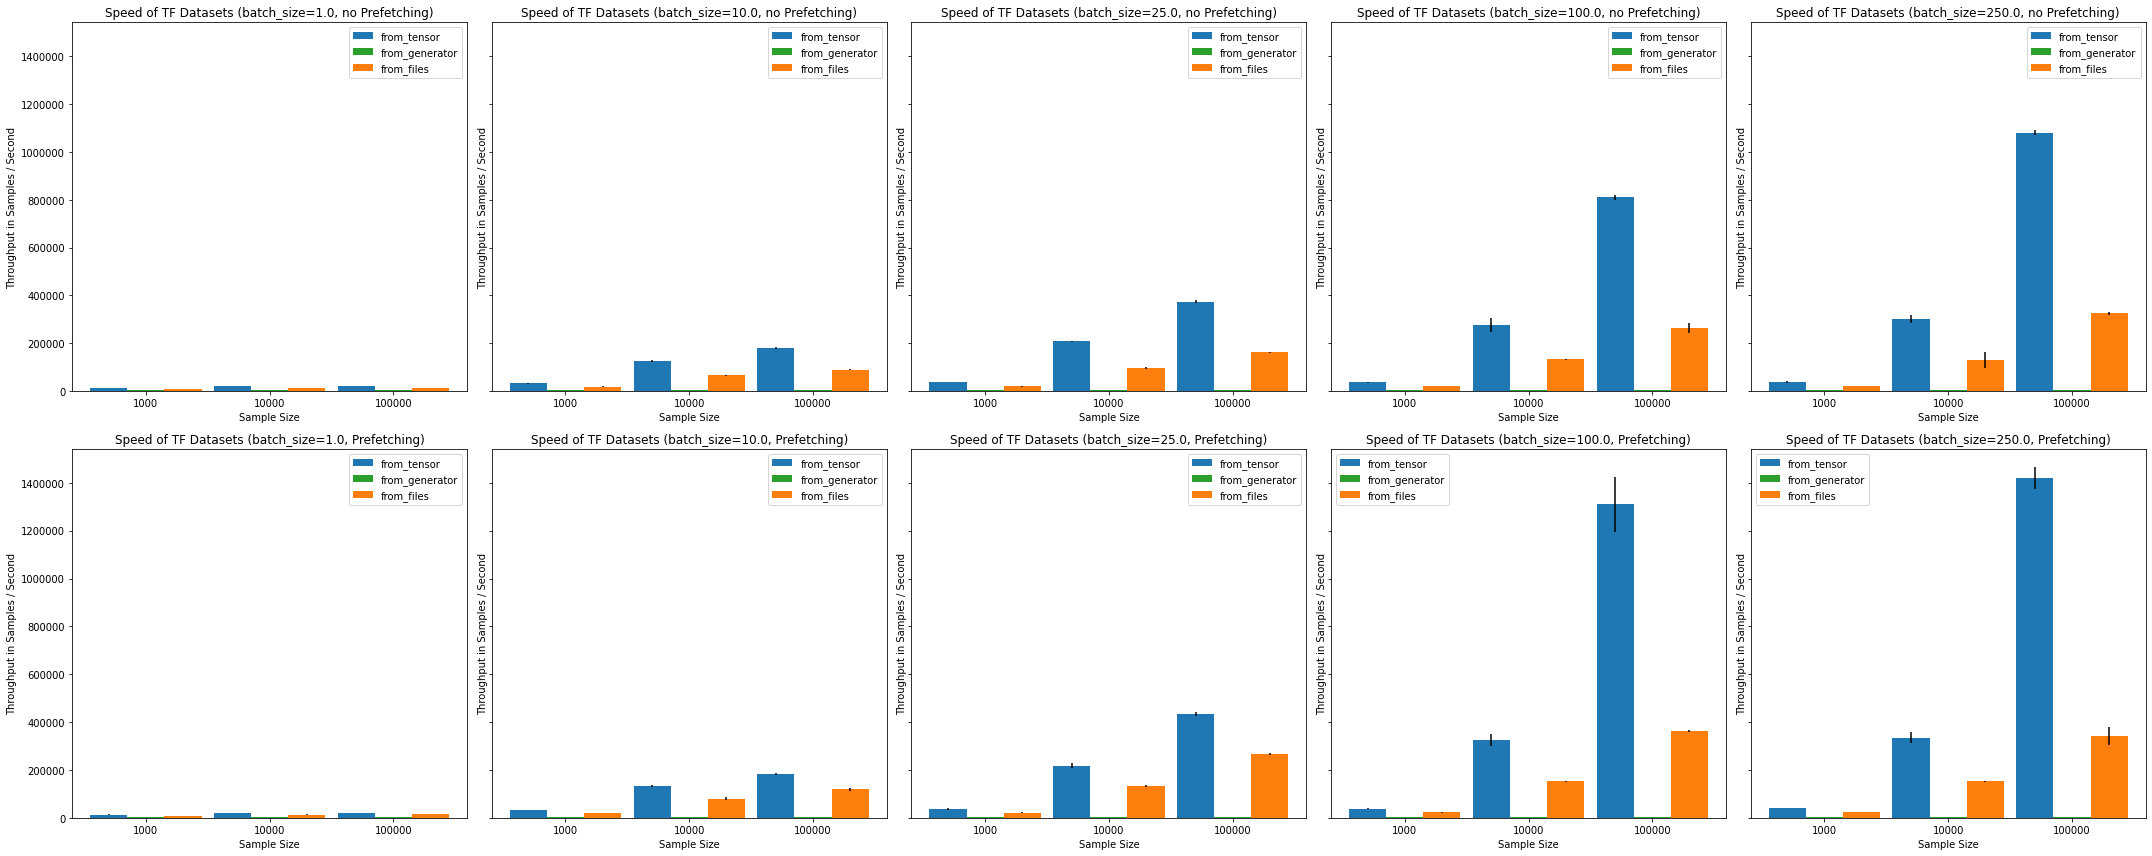

In [254]:
batch_sizes = agg_results.batch_size.unique()
prefetchings = agg_results.prefetch.unique()

size_per_subplot = 6

fig, axs = plt.subplots(
    len(prefetchings), 
    len(batch_sizes), 
    figsize=(len(batch_sizes) * size_per_subplot, len(prefetchings) * size_per_subplot), 
    sharey=True,
)

for j, prefetch in enumerate(reversed(prefetchings)):
    for i, batch_size in enumerate(batch_sizes):
        plot_speed_by_dataset_type(
            agg_results[(agg_results.batch_size == batch_size) & (agg_results.prefetch == prefetch)],
            f"Speed of TF Datasets (Batching={int(batch_size)}, {'no ' if prefetch == 0.0 else ''}Prefetching)",
            bars = ['from_tensor', 'from_generator', 'from_files'],
            ax = axs[j][i],
        )

fig.tight_layout()
plt.show()

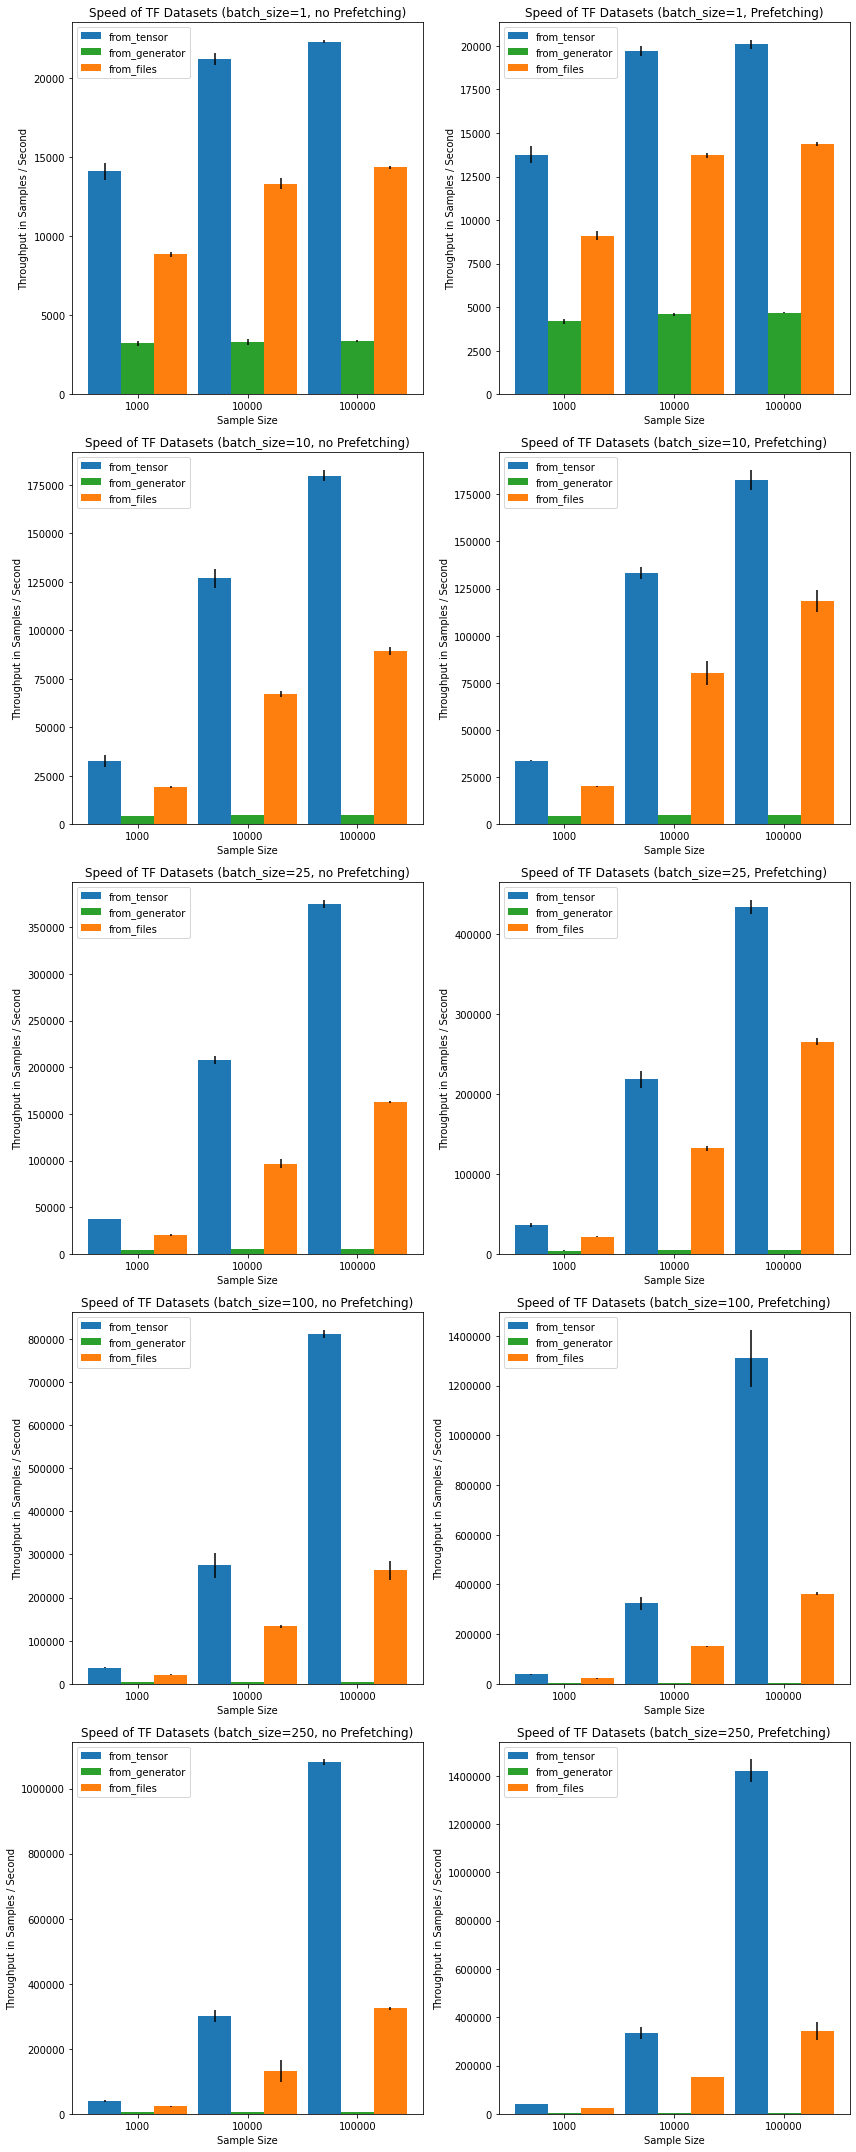

In [256]:
batch_sizes = agg_results.batch_size.unique()
prefetchings = agg_results.prefetch.unique()

size_per_subplot = 6

fig, axs = plt.subplots(
    len(batch_sizes), 
    len(prefetchings), 
    figsize=(len(prefetchings) * size_per_subplot, len(batch_sizes) * size_per_subplot), 
    sharey=False,
)

for j, prefetch in enumerate(reversed(prefetchings)):
    for i, batch_size in enumerate(batch_sizes):
        plot_speed_by_dataset_type(
            agg_results[(agg_results.batch_size == batch_size) & (agg_results.prefetch == prefetch)],
            f"Speed of TF Datasets (Batching={int(batch_size)}, {'no ' if prefetch == 0.0 else ''}Prefetching)",
            bars = ['from_tensor', 'from_generator', 'from_files'],
            ax = axs[i][j],
        )

fig.tight_layout()
plt.show()